In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import pickle

%matplotlib inline

#### Bringing in my pickle file

In [2]:
with open('../data/full_race_data.pickle', 'rb') as file:
    full = pickle.load(file)

In [3]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5162881 entries, 0 to 5162880
Data columns (total 29 columns):
 #   Column           Dtype         
---  ------           -----         
 0   track_id         object        
 1   race_date        datetime64[ns]
 2   race_number      int64         
 3   program_number   object        
 4   horse_id         int64         
 5   weight_carried   float64       
 6   jockey           object        
 7   odds             float64       
 8   finishing_place  int64         
 9   horse_name       object        
 10  course_type      object        
 11  track_condition  object        
 12  race_type        object        
 13  purse            int64         
 14  post_time        int64         
 15  latitude         float64       
 16  longitude        float64       
 17  p_lat            float64       
 18  p_lon            float64       
 19  distance_id      int64         
 20  run_up_distance  int64         
 21  trakus_index     int64         

In [5]:
pd.set_option('display.float_format', lambda x: '%.9f' % x)

In [6]:
stats = full[['seg_dist_yd', 'seg_speed_yd/s', 'seg_mph', 'cum_dist_yd', 'avg_speed_yd/s', 'avg_mph',
       'seg_accel_yd/s2']].describe()

In [7]:
stats

,seg_dist_yd,seg_speed_yd/s,seg_mph,cum_dist_yd,avg_speed_yd/s,avg_mph,seg_accel_yd/s2
count,5148039.000000000,5148039.000000000,5148039.000000000,5148039.000000000,5148039.000000000,5148039.000000000,5133197.000000000
mean,5.054495431,20.217981725,41.354962619,924.338756820,19.551513616,39.991732396,0.112472125
std,0.780589048,3.122356192,6.386637664,569.096582512,3.056169843,6.251256497,6.827646771
min,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,-2807.324784096
25%,4.824318016,19.297272064,39.471692859,446.890388984,19.564916398,40.019147177,-1.245118912
50%,5.208982634,20.835930535,42.618948821,913.467886742,20.417134723,41.762321025,0.000073513
75%,5.486963141,21.947852565,44.893334792,1354.696316072,21.015801449,42.986866600,1.330093696
max,266.173849988,1064.695399951,2177.786045355,3741.339476535,72.607097990,148.514518615,4212.903642359


In [8]:
seg_dist_IQR = (stats['seg_dist_yd'][6] - stats['seg_dist_yd'][4])

In [9]:
seg_dist_IQR

0.6626451251235936

In [10]:
high_outliers = full.loc[full['seg_dist_yd'] > (stats['seg_dist_yd'][6] + 1.5*seg_dist_IQR)]

In [11]:
len(high_outliers) / len(full) * 100

0.062465123639301394

0.0625% of all rows contain high outliers when calculated using Q3 + 1.5 * IQR

In [24]:
high_stats = high_outliers[['seg_dist_yd', 'seg_speed_yd/s', 'seg_mph', 'cum_dist_yd', 'avg_speed_yd/s', 'avg_mph',
       'seg_accel_yd/s2']].describe()

In [25]:
high_stats

,seg_dist_yd,seg_speed_yd/s,seg_mph,cum_dist_yd,avg_speed_yd/s,avg_mph,seg_accel_yd/s2
count,3225.000000000,3225.000000000,3225.000000000,3225.000000000,3225.000000000,3225.000000000,3202.000000000
mean,9.234747314,36.938989257,75.557023480,614.123038649,18.590157255,38.025321657,55.131226416
std,10.397340204,41.589360816,85.069147124,598.103740276,4.789548987,9.796804747,194.134231747
min,6.480946657,25.923786629,53.025927195,6.485716811,1.637138715,3.348692825,-1739.182423761
25%,6.591478448,26.365913793,53.930278212,162.127767444,17.853510058,36.518543301,3.721990857
50%,6.823664458,27.294657831,55.829981927,339.066253463,19.991145998,40.890980451,11.430061001
75%,7.592930851,30.371723402,62.123979687,951.203494797,21.171837222,43.306030682,28.075033414
max,266.173849988,1064.695399951,2177.786045355,2780.932114810,72.607097990,148.514518615,4212.903642359


In [12]:
def grouped_race_count(df):
    grouped_counts = (
        df
        .groupby(['track_id', 'race_date'])
        ['race_number']
        .nunique()
        .to_frame()
        .reset_index()
        .rename(columns = {'race_number' : 'number_of_races'})
    )
    
    return grouped_counts

def track_sums(df):
    track_totals = df.groupby('track_id')['number_of_races'].sum()
    return track_totals

In [13]:
high_outlier_races = grouped_race_count(high_outliers)

sum_high_outlier_races = track_sums(high_outlier_races)

In [14]:
sum_high_outlier_races

track_id
AQU    309
BEL    229
SAR    218
Name: number_of_races, dtype: int64

In [15]:
race_count = grouped_race_count(full)
sum_all_races = track_sums(race_count)
sum_all_races

track_id
AQU    825
BEL    770
SAR    396
Name: number_of_races, dtype: int64

In [16]:
def combine_and_percent(df, col_name):
    race_totals = (
        pd.merge(df, 
                 sum_all_races,  
                 right_index = True, 
                 left_index = True)
        .rename(columns = {'number_of_races_x' : col_name,
                           'number_of_races_y' : 'total_races'})
    )


    race_totals[f'percent_{col_name}'] = round(100 * race_totals[col_name]/
                                                   race_totals['total_races'], 2)
    return race_totals

In [17]:
high_outlier_overall = combine_and_percent(sum_high_outlier_races, 'races_with_high_outliers')
high_outlier_overall

,races_with_high_outliers,total_races,percent_races_with_high_outliers
track_id,,,
AQU,309,825,37.450000000
BEL,229,770,29.740000000
SAR,218,396,55.050000000


In [18]:
high_outliers['trakus_index'].describe()

count   3225.000000000
mean     119.797519380
std      114.783738803
min        2.000000000
25%       36.000000000
50%       67.000000000
75%      175.000000000
max      567.000000000
Name: trakus_index, dtype: float64

#### Redoing calculations using 3 * standard deviation instead of 1.5 * IQR

In [26]:
std = stats['seg_dist_yd'][2]
std

0.7805890478811534

In [27]:
z_high_outliers = full.loc[(full['seg_dist_yd'] > (stats['seg_dist_yd'][1] + 3*std))]
z_high_outliers

,track_id,race_date,race_number,program_number,horse_id,weight_carried,jockey,odds,finishing_place,horse_name,...,distance_id,run_up_distance,trakus_index,seg_dist_yd,seg_speed_yd/s,seg_mph,cum_dist_yd,avg_speed_yd/s,avg_mph,seg_accel_yd/s2
16328,AQU,2019-01-01,8,3,47,123.000000000,John R. Velazquez,150.000000000,1,Mind Control,...,800,54,6,16.928545299,67.714181198,138.506279722,16.928545299,11.285696866,23.084379954,270.856724790
16710,AQU,2019-01-01,8,4,48,120.000000000,Jorge A. Vargas Jr.,900.000000000,2,Our Braintrust,...,800,54,7,18.779312674,75.117250696,153.648921878,18.779312674,10.731035814,21.949845983,300.469002784
17472,AQU,2019-01-01,8,6,51,118.000000000,Junior Alvarado,245.000000000,5,Souper Jackpot,...,800,54,7,18.004464042,72.017856169,147.309251255,18.004464042,10.288265167,21.044178751,288.071424676
42563,AQU,2019-01-05,2,3,124,122.000000000,Jose Lezcano,2525.000000000,6,Stronger,...,800,54,8,11.280546394,45.122185576,92.295379588,11.280546394,5.640273197,11.536922449,180.488742306
46188,AQU,2019-01-05,3,7,126,120.000000000,Junior Alvarado,135.000000000,2,Delta Gamma,...,800,54,4,13.390641520,53.562566080,109.559794255,13.390641520,13.390641520,27.389948564,214.250264322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142222,SAR,2019-09-02,3,8,2148,120.000000000,Luis Saez,100.000000000,1,Seanow,...,700,32,27,18.978311586,75.913246344,155.277094794,78.333138436,11.604909398,23.737314677,21.009412440
5142223,SAR,2019-09-02,3,8,2148,120.000000000,Luis Saez,100.000000000,1,Seanow,...,700,32,28,20.023387116,80.093548464,163.827712768,98.356525552,14.050932222,28.740543181,16.721208482
5142224,SAR,2019-09-02,3,8,2148,120.000000000,Luis Saez,100.000000000,1,Seanow,...,700,32,29,11.902280462,47.609121847,97.382294688,110.258806014,15.208111174,31.107500129,-129.937706468
5154231,SAR,2019-09-02,8,7,749,120.000000000,Irad Ortiz Jr.,105.000000000,2,Hay Field,...,700,32,7,7.936522029,31.746088117,64.935180239,35.813112237,20.464635564,41.859481835,16.560065899


In [28]:
z_high_stats = z_high_outliers[['seg_dist_yd', 'seg_speed_yd/s', 'seg_mph', 'cum_dist_yd', 'avg_speed_yd/s', 'avg_mph',
       'seg_accel_yd/s2']].describe()
z_high_stats

,seg_dist_yd,seg_speed_yd/s,seg_mph,cum_dist_yd,avg_speed_yd/s,avg_mph,seg_accel_yd/s2
count,914.000000000,914.000000000,914.000000000,914.000000000,914.000000000,914.000000000,896.000000000
mean,15.531405316,62.125621264,127.075134404,462.175511583,16.034130851,32.797085831,170.650231408
std,18.061354383,72.245417533,147.774717681,650.862032398,7.119360946,14.562329208,335.459221265
min,7.397084428,29.588337711,60.521599863,7.398915728,1.637138715,3.348692825,-1739.182423761
25%,7.872122422,31.488489687,64.408274359,15.005811688,10.292808878,21.053472705,14.907804886
50%,9.370451344,37.481805378,76.667329181,62.992666963,17.348972837,35.486535347,76.920842830
75%,14.966883282,59.867533128,122.456317761,829.670038432,20.449137589,41.827781431,225.435089322
max,266.173849988,1064.695399951,2177.786045355,2780.932114810,72.607097990,148.514518615,4212.903642359


In [29]:
z_high_outlier_races = grouped_race_count(z_high_outliers)

sum_z_high_outlier_races = track_sums(z_high_outlier_races)

In [30]:
z_high_outlier_overall = combine_and_percent(sum_z_high_outlier_races, 'races_with_z_high_outliers')
z_high_outlier_overall

,races_with_z_high_outliers,total_races,percent_races_with_z_high_outliers
track_id,,,
AQU,111,825,13.450000000
BEL,120,770,15.580000000
SAR,112,396,28.280000000


In [31]:
z_high_outliers['trakus_index'].describe()

count   914.000000000
mean     92.910284464
std     127.728630754
min       2.000000000
25%       6.000000000
50%      19.000000000
75%     153.750000000
max     567.000000000
Name: trakus_index, dtype: float64

In [45]:
z_high_outliers['trakus_index'].value_counts().head(12)

6     70
4     62
7     58
3     47
5     43
10    28
9     28
8     28
2     18
12    15
13    12
11    11
Name: trakus_index, dtype: int64

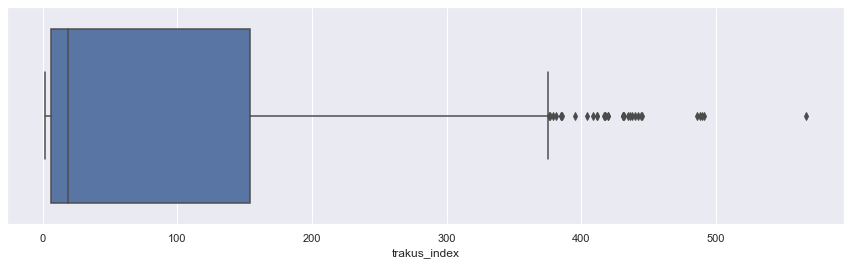

In [33]:
sns.set(rc={"figure.figsize":(15, 4)})
sns.boxplot(data=z_high_outliers, x="trakus_index");

<AxesSubplot:xlabel='trakus_index', ylabel='Count'>

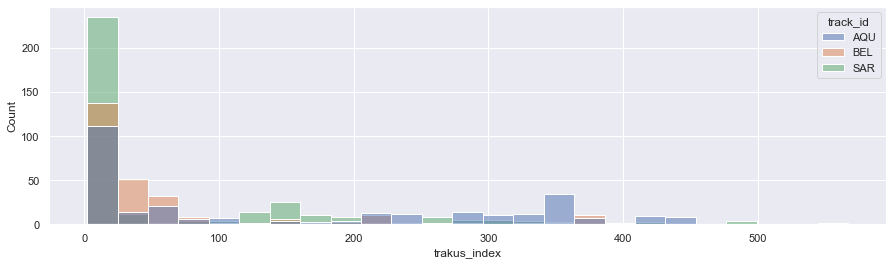

In [44]:
sns.histplot(data=z_high_outliers, x="trakus_index", hue="track_id", bins=25)

In [37]:
z_high_outliers.loc[z_high_outliers['trakus_index'] <= 20]

,track_id,race_date,race_number,program_number,horse_id,weight_carried,jockey,odds,finishing_place,horse_name,...,distance_id,run_up_distance,trakus_index,seg_dist_yd,seg_speed_yd/s,seg_mph,cum_dist_yd,avg_speed_yd/s,avg_mph,seg_accel_yd/s2
16328,AQU,2019-01-01,8,3,47,123.000000000,John R. Velazquez,150.000000000,1,Mind Control,...,800,54,6,16.928545299,67.714181198,138.506279722,16.928545299,11.285696866,23.084379954,270.856724790
16710,AQU,2019-01-01,8,4,48,120.000000000,Jorge A. Vargas Jr.,900.000000000,2,Our Braintrust,...,800,54,7,18.779312674,75.117250696,153.648921878,18.779312674,10.731035814,21.949845983,300.469002784
17472,AQU,2019-01-01,8,6,51,118.000000000,Junior Alvarado,245.000000000,5,Souper Jackpot,...,800,54,7,18.004464042,72.017856169,147.309251255,18.004464042,10.288265167,21.044178751,288.071424676
42563,AQU,2019-01-05,2,3,124,122.000000000,Jose Lezcano,2525.000000000,6,Stronger,...,800,54,8,11.280546394,45.122185576,92.295379588,11.280546394,5.640273197,11.536922449,180.488742306
46188,AQU,2019-01-05,3,7,126,120.000000000,Junior Alvarado,135.000000000,2,Delta Gamma,...,800,54,4,13.390641520,53.562566080,109.559794255,13.390641520,13.390641520,27.389948564,214.250264322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5130506,SAR,2019-09-01,11,2,3904,120.000000000,Julien R. Leparoux,195.000000000,2,Frank's Rockette,...,700,32,6,8.419736335,33.678945340,68.888751832,8.419736335,5.613157557,11.481458639,134.715781360
5141537,SAR,2019-09-02,3,3,4485,120.000000000,Ricardo Santana Jr.,790.000000000,4,Days of Glory,...,700,32,12,10.926195166,43.704780666,89.396142271,10.926195166,3.642065055,7.449678523,174.819122663
5141867,SAR,2019-09-02,3,7,446,122.000000000,Jose L. Ortiz,195.000000000,3,Thousand Percent,...,700,32,7,9.170025216,36.680100865,75.027479042,9.170025216,5.240014409,10.718211292,146.720403460
5154231,SAR,2019-09-02,8,7,749,120.000000000,Irad Ortiz Jr.,105.000000000,2,Hay Field,...,700,32,7,7.936522029,31.746088117,64.935180239,35.813112237,20.464635564,41.859481835,16.560065899


In [62]:
#rows per race that qualify as a high outlier using the (mean + 3*std)
(
    z_high_outliers
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .count()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .head(60)
)

horse_id
track_id race_date  race_number          
AQU      2019-11-17 6                  20
         2019-11-01 2                  19
SAR      2019-07-26 7                  18
AQU      2019-11-15 6                  17
BEL      2019-10-12 5                  12
SAR      2019-08-03 6                  11
         2019-08-04 2                  11
         2019-07-17 8                  11
BEL      2019-10-02 5                   9
AQU      2019-11-17 7                   9
SAR      2019-08-03 3                   9
         2019-07-27 4                   9
BEL      2019-06-19 9                   9
SAR      2019-09-02 3                   9
         2019-07-21 10                  8
         2019-07-13 5                   8
         2019-08-04 6                   8
BEL      2019-06-02 3                   8
AQU      2019-02-18 8                   8
         2019-11-01 8                   8
         2019-01-26 8                   8
SAR      2019-08-03 2                   8
BEL      2019-06-23 2                   8
SAR      2019-07-13 10                  7
AQU      2019-11-07 7                   7
         2019-02-18 3                   7
BEL      2019-09-27 4                   6
         2019-10-13 4                   6
SAR      2019-08-15 5                   6
AQU      2019-11-03 9                   6
BEL      2019-09-29 3                   6
SAR      2019-07-26 1                   6
AQU      2019-11-17 10                  6
         2019-11-08 8                   6
SAR      2019-07-28 2                   6
         2019-08-07 7                   6
         2019-08-16 2                   5
AQU      2019-11-08 9                   5
         2019-11-17 3                   5
SAR      2019-07-17 7                   5
         2019-08-11 7                   5
AQU      2019-12-01 4                   5
SAR      2019-07-18 1                   5
                    3                   5
BEL      2019-09-21 10                  5
         2019-09-18 8                   5
SAR      2019-07-24 3                   5
BEL      2019-09-11 5                   5
SAR      2019-08-17 2                   5
         2019-07-28 4                   5
AQU      2019-03-15 9                   5
SAR      2019-07-17 2                   5
BEL      2019-10-18 4                   5
AQU      2019-11-01 1                   5
SAR      2019-07-21 5                   4
AQU      2019-02-15 5                   4
SAR      2019-07-21 7                   4
BEL      2019-09-21 8                   4
         2019-09-19 8                   4
         2019-09-18 5                   4

In [66]:
(
    z_high_outliers
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .count()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .describe()
)

,horse_id
count,343.000000000
mean,2.664723032
std,2.736179065
min,1.000000000
25%,1.000000000
50%,2.000000000
75%,3.000000000
max,20.000000000


In [63]:
#horses per race that qualify as a high outlier using the (mean + 3*std)
(
    z_high_outliers
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .nunique()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .head(60)
)

horse_id
track_id race_date  race_number          
AQU      2019-11-01 2                  11
         2019-11-17 7                   9
SAR      2019-07-26 7                   9
         2019-08-03 3                   8
         2019-07-26 1                   6
AQU      2019-11-03 9                   6
SAR      2019-07-17 8                   6
AQU      2019-11-17 6                   5
SAR      2019-07-13 10                  5
AQU      2019-11-15 6                   5
SAR      2019-07-28 4                   5
BEL      2019-09-27 4                   5
SAR      2019-07-24 3                   5
         2019-07-17 2                   5
AQU      2019-12-01 4                   5
BEL      2019-09-14 5                   4
SAR      2019-08-15 5                   4
         2019-08-31 7                   4
AQU      2019-12-15 4                   4
SAR      2019-08-04 2                   4
AQU      2019-12-28 6                   4
BEL      2019-09-19 8                   4
SAR      2019-08-18 2                   4
         2019-09-01 8                   4
         2019-08-16 2                   4
BEL      2019-09-14 7                   4
SAR      2019-08-22 4                   4
         2019-07-21 10                  4
         2019-07-18 1                   4
         2019-08-17 2                   4
         2019-07-17 7                   4
         2019-08-08 4                   3
         2019-08-04 6                   3
AQU      2019-11-17 3                   3
         2019-11-27 3                   3
         2019-01-01 8                   3
SAR      2019-07-24 10                  3
         2019-08-03 6                   3
AQU      2019-12-22 8                   3
SAR      2019-07-28 2                   3
         2019-08-11 7                   3
         2019-07-21 7                   3
                    2                   3
BEL      2019-09-07 5                   3
         2019-09-18 8                   3
         2019-10-26 9                   3
         2019-09-21 10                  3
         2019-09-22 10                  3
         2019-10-23 7                   3
         2019-10-19 5                   3
AQU      2019-11-08 9                   3
         2019-12-22 2                   3
SAR      2019-08-15 8                   3
         2019-08-14 8                   3
         2019-08-11 8                   3
AQU      2019-11-01 4                   3
SAR      2019-08-17 7                   3
AQU      2019-11-07 7                   3
SAR      2019-08-11 10                  3
         2019-09-02 3                   3

#### Exploring 0 distance segments

In [38]:
zero_dist = full.loc[full['seg_dist_yd']==0]

zero_dist_races = grouped_race_count(zero_dist)

sum_zero_dist_races = track_sums(zero_dist_races)

zero_dist_overall = combine_and_percent(sum_zero_dist_races, 'races_with_zero_distance_segments')
zero_dist_overall

,races_with_zero_distance_segments,total_races,percent_races_with_zero_distance_segments
track_id,,,
AQU,76,825,9.210000000
BEL,94,770,12.210000000
SAR,108,396,27.270000000


In [39]:
zero_dist['trakus_index'].describe()

count   3309.000000000
mean      42.428528256
std       98.041144453
min        2.000000000
25%        3.000000000
50%        5.000000000
75%       14.000000000
max      395.000000000
Name: trakus_index, dtype: float64

In [46]:
zero_dist['trakus_index'].value_counts().head(12)

2     551
3     463
4     374
5     301
6     203
7     143
8     115
9      90
10     65
11     59
12     52
13     45
Name: trakus_index, dtype: int64

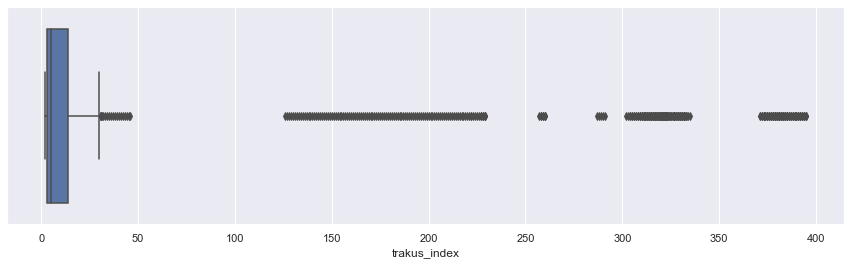

In [41]:
sns.set(rc={"figure.figsize":(15, 4)})
sns.boxplot(data=zero_dist, x="trakus_index");

<AxesSubplot:xlabel='trakus_index', ylabel='Count'>

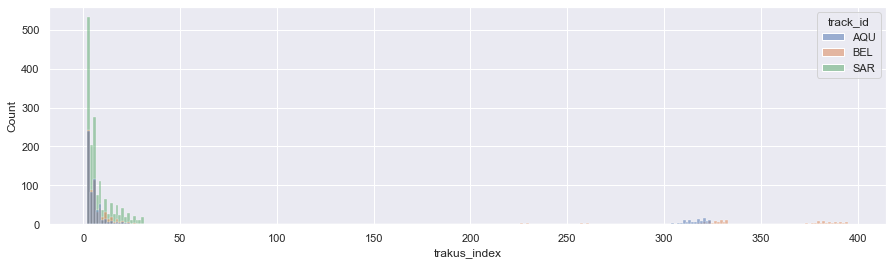

In [42]:
sns.histplot(data=zero_dist, x="trakus_index", hue="track_id")

In [60]:
#rows for a given race with 0 segment distance
(
    zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .count()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .head(60)
)

horse_id
track_id race_date  race_number          
SAR      2019-07-24 2                 300
                    5                 176
AQU      2019-11-15 5                 111
SAR      2019-08-04 6                 105
AQU      2019-11-17 6                  94
BEL      2019-09-18 2                  72
         2019-06-01 3                  61
SAR      2019-07-17 8                  55
         2019-09-02 3                  42
         2019-08-03 3                  41
AQU      2019-11-03 9                  33
SAR      2019-08-17 2                  32
         2019-07-24 10                 30
         2019-08-03 6                  28
         2019-09-01 8                  27
         2019-07-28 4                  27
BEL      2019-10-02 5                  27
         2019-10-14 1                  25
AQU      2019-03-15 9                  24
SAR      2019-07-13 10                 23
BEL      2019-09-14 7                  23
SAR      2019-07-18 1                  23
AQU      2019-11-27 3                  23
BEL      2019-07-04 3                  22
SAR      2019-08-11 8                  22
         2019-08-17 10                 22
BEL      2019-09-19 8                  21
SAR      2019-08-15 3                  21
         2019-08-14 8                  21
         2019-07-21 2                  21
BEL      2019-09-27 4                  20
SAR      2019-08-08 4                  20
BEL      2019-10-26 4                  20
SAR      2019-08-17 11                 20
         2019-07-21 11                 20
         2019-07-13 1                  19
         2019-07-14 9                  19
BEL      2019-09-18 5                  19
SAR      2019-07-13 5                  19
         2019-07-28 2                  19
         2019-07-17 9                  18
BEL      2019-09-29 5                  18
         2019-09-28 9                  18
         2019-09-15 1                  18
SAR      2019-08-17 7                  17
         2019-08-18 3                  17
         2019-08-15 5                  17
AQU      2019-12-07 5                  16
         2019-02-18 5                  16
         2019-01-25 5                  16
         2019-12-01 4                  16
BEL      2019-09-14 5                  16
         2019-10-23 7                  16
SAR      2019-07-18 3                  15
BEL      2019-09-12 4                  15
SAR      2019-08-31 7                  15
                    9                  15
AQU      2019-04-14 5                  15
         2019-11-17 3                  15
SAR      2019-08-02 2                  14

In [64]:
(
    zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .count()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .describe()
)
#stats for this data; for races with 0 distance segments, mean of 12 rows, median of 7

,horse_id
count,278.000000000
mean,11.902877698
std,24.108238005
min,1.000000000
25%,3.000000000
50%,7.000000000
75%,13.000000000
max,300.000000000


In [61]:
#horses in a given race with 0 segment distance
(
    zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .nunique()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .head(60)
)

horse_id
track_id race_date  race_number          
AQU      2019-11-15 5                  10
SAR      2019-07-24 2                  10
         2019-08-03 3                   9
         2019-08-17 11                  8
         2019-07-24 5                   8
         2019-07-17 8                   7
         2019-07-13 10                  7
         2019-07-28 4                   7
         2019-07-21 2                   6
BEL      2019-09-18 2                   6
AQU      2019-11-17 6                   6
         2019-12-01 4                   6
         2019-11-03 9                   6
SAR      2019-08-14 8                   6
         2019-07-13 1                   6
         2019-09-01 8                   6
         2019-07-24 10                  6
         2019-08-15 5                   5
         2019-07-24 3                   5
         2019-08-16 2                   5
BEL      2019-09-18 8                   5
SAR      2019-08-17 2                   5
         2019-08-11 8                   5
AQU      2019-12-15 6                   5
SAR      2019-08-08 4                   5
BEL      2019-09-08 5                   5
SAR      2019-07-26 1                   5
         2019-08-03 6                   5
         2019-07-28 2                   5
BEL      2019-09-14 5                   4
SAR      2019-08-14 5                   4
AQU      2019-02-18 5                   4
BEL      2019-09-27 4                   4
SAR      2019-08-15 3                   4
         2019-08-31 7                   4
         2019-07-18 1                   4
BEL      2019-09-19 8                   4
AQU      2019-12-22 8                   4
SAR      2019-07-14 10                  4
         2019-08-31 9                   4
BEL      2019-09-14 7                   4
AQU      2019-11-17 3                   4
BEL      2019-09-21 8                   4
SAR      2019-08-17 7                   4
BEL      2019-09-11 5                   4
SAR      2019-08-17 10                  4
         2019-08-23 8                   4
AQU      2019-12-15 4                   4
SAR      2019-08-02 2                   4
         2019-09-02 3                   4
         2019-07-17 7                   4
         2019-08-03 5                   3
BEL      2019-09-21 4                   3
SAR      2019-08-07 8                   3
AQU      2019-12-22 2                   3
BEL      2019-06-23 2                   3
         2019-09-12 4                   3
         2019-06-01 3                   3
SAR      2019-08-08 5                   3
BEL      2019-09-18 5                   3

In [65]:
(
    zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .nunique()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .describe()
)

,horse_id
count,278.000000000
mean,2.154676259
std,1.733456013
min,1.000000000
25%,1.000000000
50%,1.000000000
75%,3.000000000
max,10.000000000


#### Putting together the high outlier (based on 3*std) and zero distance segments

In [68]:
high_zero_dist = full.loc[(full['seg_dist_yd'] > (stats['seg_dist_yd'][1] + 3*std)) | (full['seg_dist_yd']==0)]

high_zero_dist_races = grouped_race_count(high_zero_dist)

sum_high_zero_dist_races = track_sums(high_zero_dist_races)

high_zero_dist_overall = combine_and_percent(sum_high_zero_dist_races, 'races_with_high_or_zero_distance_segments')
high_zero_dist_overall

,races_with_high_or_zero_distance_segments,total_races,percent_races_with_high_or_zero_distance_segments
track_id,,,
AQU,124,825,15.030000000
BEL,136,770,17.660000000
SAR,131,396,33.080000000


<AxesSubplot:xlabel='trakus_index', ylabel='Count'>

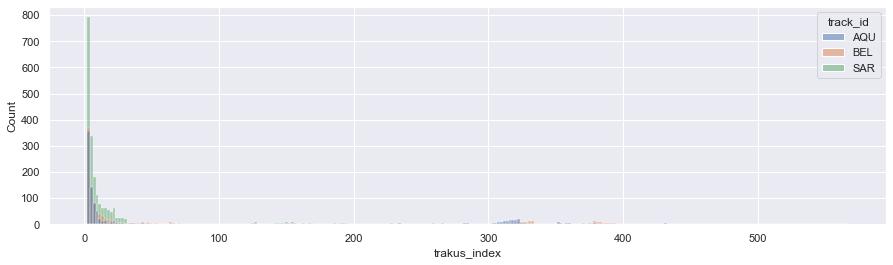

In [69]:
sns.histplot(data=high_zero_dist, x="trakus_index", hue="track_id")

In [70]:
high_zero_dist['trakus_index'].value_counts().head(20)

2     569
3     510
4     436
5     344
6     273
7     201
8     143
9     118
10     93
11     70
12     67
13     57
14     52
15     48
16     43
17     41
18     39
19     36
20     35
21     32
Name: trakus_index, dtype: int64

In [81]:
#rows for a given race with high or 0 segment distance
(
    high_zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .count()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .head(20)
)

horse_id
track_id race_date  race_number          
SAR      2019-07-24 2                 300
                    5                 176
AQU      2019-11-17 6                 114
SAR      2019-08-04 6                 113
AQU      2019-11-15 5                 111
BEL      2019-09-18 2                  72
SAR      2019-07-17 8                  66
BEL      2019-06-01 3                  61
SAR      2019-09-02 3                  51
         2019-08-03 3                  50
AQU      2019-11-03 9                  39
SAR      2019-08-03 6                  39
         2019-08-17 2                  37
BEL      2019-10-02 5                  36
SAR      2019-07-24 10                 33
         2019-07-28 4                  32
         2019-09-01 8                  31
         2019-07-13 10                 30
AQU      2019-03-15 9                  29
SAR      2019-07-18 1                  28

In [73]:
#rows for a given race with 0 segment distance
(
    high_zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .count()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .describe()
)

,horse_id
count,391.000000000
mean,10.800511509
std,21.528778587
min,1.000000000
25%,2.000000000
50%,6.000000000
75%,13.000000000
max,300.000000000


In [87]:
#horses in a given race with 0 segment distance
(
    high_zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .nunique()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .head(65)
)

horse_id
track_id race_date  race_number          
AQU      2019-11-01 2                  11
         2019-11-15 5                  10
SAR      2019-07-24 2                  10
         2019-08-03 3                   9
AQU      2019-11-17 7                   9
...                                   ...
SAR      2019-08-17 10                  4
         2019-09-02 3                   4
         2019-08-04 2                   4
BEL      2019-06-01 1                   3
         2019-10-23 7                   3

[65 rows x 1 columns]

In [75]:
(
    high_zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .nunique()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .describe()
)

,horse_id
count,391.000000000
mean,2.081841432
std,1.743398592
min,1.000000000
25%,1.000000000
50%,1.000000000
75%,2.000000000
max,11.000000000


In [ ]:
# Josh's angle formula
def get_angle_robust(point1, point2):
    try:
        vector_1 = np.array(point1)
        vector_2 = np.array(point2)
        unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
        unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
        dot_product = np.dot(unit_vector_1, unit_vector_2)
        angle = np.arccos(dot_product)
        return angle
    except:
        return np.nan

In [ ]:
with ThreadPoolExecutor(500) as executor:
    res = executor.map(vincenty_robust, complete['latlon'], complete['latlon_shift'])
complete['segment_distance'] = list(res)